In [3]:
#https://github.com/OceanParcels/GlobalMassBudget/blob/main/create_river_input.py

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import timeit
import matplotlib.colors as colors
import csv
import shapefile
import cartopy
import glob
from datetime import datetime
import os

In [4]:
import geopandas as gpd
import pandas as pd

In [5]:
mask_land = xr.open_dataset('../../data/output_data/masks/mask_land_NEMO0083.nc')['mask_land']
mask_land_nan = mask_land.copy().values.astype(float)
mask_land_nan[~mask_land] = np.nan
mask_lons,mask_lats = mask_land['lon'].values, mask_land['lat'].values
#fieldMesh_x,fieldMesh_y = np.meshgrid(lons.ravel(),lats.ravel())

In [6]:
files_fisheries = sorted(glob.glob('../../data/release/GlobalFishingWatch/fleet*/*') )

In [7]:
date_array = pd.date_range(datetime(2020,1,1),datetime(2021,1,1),freq='MS')    
delta_date_array = (( np.array(date_array) - np.datetime64(datetime(1970,1,1)) ) ).astype('timedelta64[s]').astype(int)


In [8]:
## Fisheries data is provided on a 0.01x0.01 grid with extent [-180,180]x[-90,90]
# e.g. # print(np.unique(sorted(data_fisheries['cell_ll_lat'].values)))
# and  # print(np.unique(sorted(data_fisheries['cell_ll_lon'].values)))
# We will create a grid to bin these on
dlon = 0.01
dlat = 0.01
lons = np.arange(-180,180,step=dlon)
lats = np.arange(-90,90,step=dlat)
fieldMesh_x,fieldMesh_y = np.meshgrid(lons,lats)


lons_edge = lons - .5*dlon
lats_edge = lats - .5*dlat
lons_edge = np.append(lons_edge,lons_edge[-1]+dlon)
lats_edge = np.append(lats_edge,lats_edge[-1]+dlat)
#mesh_plot_x,mesh_plot_y = np.meshgrid(lons_edge,lats_edge)


dlon_f,dlat_f = 0.01,0.01




input_fisheries = np.zeros([len(date_array)-1,fieldMesh_x.shape[0],fieldMesh_y.shape[1]])
for file_ in files_fisheries:
    
    date = datetime.fromisoformat(os.path.basename(file_).split('.')[0])
    if date.day == 1:
        print(date)
    delta_date = ((np.datetime64(date) - np.datetime64(datetime(1970,1,1))) ).astype('timedelta64[s]').astype(int)
    
    data_fisheries = pd.read_csv(file_)

    data_fishing_hours = data_fisheries[data_fisheries['fishing_hours'] > 0]

    i_lat = np.digitize(data_fishing_hours['cell_ll_lat']+.5*dlat_f, lats_edge)-1
    i_lon = (np.digitize(data_fishing_hours['cell_ll_lon']+.5*dlon_f, lons_edge)-1) % len(lons)
    i_time = (np.digitize(delta_date,delta_date_array)-1) * np.ones(len(i_lat),dtype=int)
    
    input_fisheries[i_time,i_lat,i_lon] += data_fishing_hours['fishing_hours'].values

2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00
2020-08-01 00:00:00
2020-09-01 00:00:00
2020-10-01 00:00:00
2020-11-01 00:00:00
2020-12-01 00:00:00


In [9]:
input_fisheries.shape

(12, 18000, 36000)

In [11]:
def to_netcdf(output_filename,data,data_name,lons,lats,time,explanation='',encode=False):
    '''
    All data is written to netcdf files to speed up computations
    '''
    dict_data = {}
    for name_, data_ in zip(data_name, data):
        dict_data[name_] = (( "time","lat", "lon"), data_ )
    dict_data['explanation'] = explanation
        
    ds = xr.Dataset(
        dict_data,
        coords={
            "lon": lons,
            "lat": lats,
            "time": time,
        },
    )   
    if encode:
        ds.to_netcdf(output_filename,encoding={name_: {'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -9999}})
    else:
        ds.to_netcdf(output_filename)

to_netcdf('../../data/release/generated_files/input_fisheries.nc',[input_fisheries],['fishing_hours'],lons,lats,date_array[:-1],explanation='Total fishing hours per month, calculated from the Global Fishing Watch v2 dataset')

/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_33425/3223585266.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(mask_lons,mask_lats,mask_land_nan)


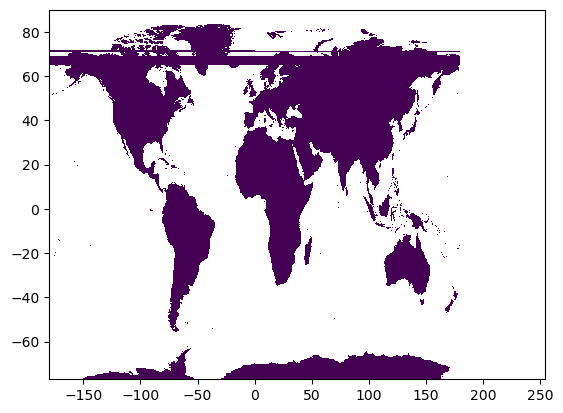

In [12]:
plt.pcolormesh(mask_lons,mask_lats,mask_land_nan)
plt.show()


In [17]:
plt.pcolormesh(fieldMesh_x,fieldMesh_y,np.sum(input_fisheries, axis=0),norm=colors.LogNorm(vmin=1e-3,vmax=1e2))
plt.colorbar()
plt.show()

: 

In [16]:
np.sum(input_fisheries, axis=0).shape

(18000, 36000)